In [1]:
import scanpy as sc
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

from tqdm import tqdm_notebook

In [2]:
sc.set_figure_params(dpi=100)

In [3]:
from statsmodels.stats.multitest import multipletests

def visualize_de(adata, cat_name, 
                 key='rank_genes_groups',
                 binarize=False,
                 pval_cutoff=0.1,
                 lfc=1.5,
                 std_expression=True, 
                 layer=None, 
                 figsize=(25,6),
                 mean_plot_name=None,
                 pval_plot_name=None):

    ## top genes
    de = tidy_up_scanpy_de_all(adata, cat_name, key=key)    
    de = de[(de.pvalsadj <= pval_cutoff) & (de.log2foldchanges > lfc)]
    top_genes = list(set(de.names))
    print('%s DE genes' % len(top_genes))
    assert len(top_genes) < 2000, 'Too many DE genes...'
    
    pvals_adj = tidy_up_scanpy_de(adata, cat_name, key=key)    
    pvals_adj_long = pvals_adj
    pvals_adj_long[cat_name] = pvals_adj_long.index
    pvals_adj_long = pvals_adj_long.melt(cat_name, var_name='gene', value_name='pvaladj').sort_values('pvaladj')
    pvals_adj_long = pvals_adj_long[pvals_adj_long.gene.isin(top_genes)].reset_index()

    if layer is None:
        x = adata[:, top_genes].X.toarray()
    else:
        x = adata[:, top_genes].layers[layer]

    if binarize:
        xdf = pd.DataFrame((x > 0).astype(np.float32), columns=top_genes)
    else:
        xdf = pd.DataFrame(x, columns=top_genes)
    
    xdf_mean = xdf.groupby(adata.obs[cat_name].values).mean()
    cm = sns.clustermap(xdf_mean, standard_scale=1 if std_expression else None, cmap='viridis', figsize=figsize, row_cluster=False);
    if mean_plot_name: cm.savefig(mean_plot_name)

    ## P values
    #ridx = cm.dendrogram_row.reordered_ind
    cidx = cm.dendrogram_col.reordered_ind

    pval_mat = pvals_adj.loc[:, top_genes]
    pval_mat[pval_mat == 0.0] = 1e-300
    pval_mat = -np.log10(pval_mat)
    pval_mat[pval_mat<np.log10(pval_cutoff)] = 0
    pval_mat = pval_mat.rename_axis(None, axis=0).rename_axis(None, axis=1)

    cm = sns.clustermap(pval_mat.iloc[:, cidx], cmap='Reds', figsize=figsize, col_cluster=False, row_cluster=False)
    if pval_plot_name: cm.savefig(pval_plot_name)

def tidy_up_scanpy_de_all(ad, groupby, key='rank_genes_groups'):

    dfs = []

    for c in ad.obs[groupby].cat.categories:
        names = pd.DataFrame(ad.uns[key]['names'][c], columns=['names'])
        
        scores = pd.DataFrame(ad.uns[key]['scores'][c], columns=['tstat'])
        lfc = pd.DataFrame(ad.uns[key]['logfoldchanges'][c], columns=['log2foldchanges'])
        pvals = pd.DataFrame(ad.uns[key]['pvals'][c], columns=['pvals'])

        pvalsadj = pd.DataFrame(ad.uns[key]['pvals_adj'][c], columns=['pvalsadj'])
        pvalsadj.values[pvalsadj.values > 1.] = 1. # workaround for scanpy bug

        df = pd.concat([names, scores, lfc, pvals, pvalsadj], axis=1)
        df['group'] = c
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['group'] = df['group'].astype('category')
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    return df

    
def tidy_up_scanpy_de(ad, groupby, key='rank_genes_groups'):

    dfs = []

    for c in ad.obs[groupby].cat.categories:
        names = pd.DataFrame(ad.uns[key]['names'][c], columns=['names'])
        pvalsadj = pd.DataFrame(ad.uns[key]['pvals_adj'][c], columns=['pvalsadj'])
        pvalsadj.values[pvalsadj.values > 1.] = 1. # workaround for scanpy bug
        df = pd.concat([names, pvalsadj], axis=1)
        df['group'] = c
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['group'] = df['group'].astype('category')
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    return df.pivot_table('pvalsadj', index='names', columns='group').T

## Read the data

In [4]:
adata = sc.read('results/hdst-lowres-5x-smooth-0.5sigma.h5ad')
adata

AnnData object with n_obs × n_vars = 35289 × 16208 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    layers: 'smooth_overall'

In [5]:
adata.obs['index'] = [f'{x}x{y}' for x,y in zip(adata.obs.x, adata.obs.y)]
adata.obs.set_index('index', inplace=True)
adata.obs.head()

,x,y,Ependymal Cell Zone (E),External Plexiform Layer (EPL),Glomerular Layer (GL),Granule Cell Layer External (GCL-E),Granule Cell Layer Internal (GCL-I),Internal Plexiform Layer (IPL),Mitral Layer (M/T),ND,Olfactory Nerve Layer (ONL),Rostral Migratory System (RMS),region
index,,,,,,,,,,,,,
95x54,95,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL)
95x55,95,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL)
95x56,95,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL)
95x57,95,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL)
95x58,95,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL)


### Exclude GM genes

In [6]:
import re

gm_genes = adata.var_names[[re.match('Gm[0-9]{2,}', x) is not None for x in adata.var_names]]
gm_genes[:20].values

adata = adata[:, ~adata.var_names.isin(gm_genes)].copy()
adata

AnnData object with n_obs × n_vars = 35289 × 14041 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region'
    var: 'gene_symbols', 'gene_ids'
    layers: 'smooth_overall'

## Cell types

In [7]:
celltype = pd.read_csv('data/celltypes/ct_likelihoods_unmodgtf_li_low_fastp_1000.tsv', sep='\t')
celltype.head()

,x,y,ClusterName,bin,lk,count,umi_distrib,emp_pval,lk_rat,lk_norm,lk_rand,second_best_ct,emp_pval_adjust_BH,emp_pval_adjust_Bf,bc,ClusterName_simpl,N_ct
0,156,66,OBINH5_Neurons_57,5x,-117.382063,12,"c(1,1,1,1,1,1,1,1,1,1,1,1)",4.229914e-07,0.013018,0.005803,-110.524084,COP1_Oligos_25,0.000003,0.013625,156_66,Neurons,1
1,156,66,OBNBL1_Neurons_90,5x,-115.403654,12,"c(1,1,1,1,1,1,1,1,1,1,1,1)",1.918908e-06,0.094137,0.041966,-110.524084,COP1_Oligos_25,0.000006,0.061808,156_66,Neurons,1
2,156,66,OBDOP2_Neurons_116,5x,-118.473364,12,"c(1,1,1,1,1,1,1,1,1,1,1,1)",1.132557e-06,0.004371,0.001949,-110.524084,COP1_Oligos_25,0.000004,0.036480,156_66,Neurons,1
3,156,66,OBINH2_Neurons_117,5x,-118.791141,12,"c(1,1,1,1,1,1,1,1,1,1,1,1)",1.456069e-06,0.003181,0.001418,-110.524084,COP1_Oligos_25,0.000003,0.046900,156_66,Neurons,1
4,156,66,OBINH3_Neurons_118,5x,-118.957074,12,"c(1,1,1,1,1,1,1,1,1,1,1,1)",1.856721e-06,0.002695,0.001201,-110.524084,COP1_Oligos_25,0.000005,0.059805,156_66,Neurons,1


In [10]:
celltype = celltype[(celltype.bin == '5x') & (celltype.lk_norm >= 0.1) & (celltype.emp_pval_adjust_BH <= 0.01) & (celltype.lk_rat >= 0.8)]

celltypes = celltype.ClusterName.astype('category').cat.categories

celltype['index'] = [f'{x}x{y}' for x,y in zip(celltype.x, celltype.y)]
celltype = celltype.set_index('index').sort_values('ClusterName')
del celltype['x']
del celltype['y']
celltype.head()

In [11]:
celltype.ClusterName.astype('category').cat.categories

Index(['ABC_Vascular_213', 'ACBG_Astrocytes_231', 'ACMB_Astrocytes_237',
       'ACNT1_Astrocytes_235', 'ACNT2_Astrocytes_236', 'ACOB_Astrocytes_232',
       'ACTE1_Astrocytes_233', 'ACTE2_Astrocytes_234', 'CHOR_Ependymal_240',
       'COP1_Oligos_25', 'COP2_Oligos_24', 'ENMFB_Vascular_16',
       'ENTG1_PeripheralGlia_9', 'ENTG2_PeripheralGlia_11',
       'ENTG3_PeripheralGlia_12', 'ENTG4_PeripheralGlia_10',
       'ENTG5_PeripheralGlia_14', 'ENTG6_PeripheralGlia_13',
       'ENTG7_PeripheralGlia_15', 'EPEN_Ependymal_238', 'EPMB_Ependymal_114',
       'EPSC_Ependymal_239', 'HYPEN_Ependymal_115', 'MFOL1_Oligos_19',
       'MFOL2_Oligos_21', 'MGL1_Immune_223', 'MGL2_Immune_224',
       'MGL3_Immune_225', 'MOL1_Oligos_20', 'MOL2_Oligos_18', 'MOL3_Oligos_17',
       'NFOL1_Oligos_22', 'NFOL2_Oligos_23', 'OBDOP1_Neurons_211',
       'OBDOP2_Neurons_116', 'OBINH1_Neurons_119', 'OBINH2_Neurons_117',
       'OBINH3_Neurons_118', 'OBINH4_Neurons_120', 'OBINH5_Neurons_57',
       'OBNBL1_Neuron

In [12]:
vip_celltypes = list({x.split('_')[0] for x in celltype.ClusterName})
vip_celltypes = sorted(vip_celltypes)
vip_celltypes[:20], len(vip_celltypes)

(['ABC',
  'ACBG',
  'ACMB',
  'ACNT1',
  'ACNT2',
  'ACOB',
  'ACTE1',
  'ACTE2',
  'CHOR',
  'COP1',
  'COP2',
  'ENMFB',
  'ENTG1',
  'ENTG2',
  'ENTG3',
  'ENTG4',
  'ENTG5',
  'ENTG6',
  'ENTG7',
  'EPEN'],
 63)

### Merge cell type info

In [13]:
celltype_pv = celltype[['ClusterName', 'lk_norm']].pivot(columns='ClusterName', values='lk_norm')
celltype_index = celltype_pv.columns

celltype_pv['celltype_lknorm01'] = [celltype_index[np.nanargmax(r[1].values)] if ~np.all(np.isnan(r[1].values)) else np.nan for r in celltype_pv.iterrows()]
celltype_pv = celltype_pv[['celltype_lknorm01']]
celltype_pv.head(30)

ClusterName,celltype_lknorm01
index,
100x100,ENTG2_PeripheralGlia_11
100x103,OBINH5_Neurons_57
100x104,EPSC_Ependymal_239
100x107,OBINH2_Neurons_117
100x108,MGL3_Immune_225
100x109,PVM1_Immune_227
100x110,OBINH4_Neurons_120
100x111,VSMCA_Vascular_216
100x112,EPEN_Ependymal_238


### Add celltypes assignments to barcodes

In [14]:
adata.obs['celltype'] = celltype_pv.celltype_lknorm01
adata.obs['celltype_simple'] = [x.split('_')[1] if isinstance(x, str) else np.nan for x in adata.obs['celltype'].values]

adata.obs.celltype = adata.obs.celltype.astype(str).astype('category')
adata.obs.celltype_simple = adata.obs.celltype_simple.astype(str).astype('category')

adata.obs.head(12)

,x,y,Ependymal Cell Zone (E),External Plexiform Layer (EPL),Glomerular Layer (GL),Granule Cell Layer External (GCL-E),Granule Cell Layer Internal (GCL-I),Internal Plexiform Layer (IPL),Mitral Layer (M/T),ND,Olfactory Nerve Layer (ONL),Rostral Migratory System (RMS),region,celltype,celltype_simple
index,,,,,,,,,,,,,,,
95x54,95,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),nan,nan
95x55,95,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),OBNBL1_Neurons_90,Neurons
95x56,95,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),nan,nan
95x57,95,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),nan,nan
95x58,95,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),nan,nan
95x59,95,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),OBNBL1_Neurons_90,Neurons
95x60,95,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),nan,nan
96x53,96,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),nan,nan
96x54,96,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Olfactory Nerve Layer (ONL),ACMB_Astrocytes_237,Astrocytes


### Filter out unassigned barcodes

In [15]:
adata._inplace_subset_obs(adata.obs.celltype != 'nan')
adata._inplace_subset_var(adata.X.sum(0) > 0.)
adata

AnnData object with n_obs × n_vars = 26517 × 13549 
    obs: 'x', 'y', 'Ependymal Cell Zone (E)', 'External Plexiform Layer (EPL)', 'Glomerular Layer (GL)', 'Granule Cell Layer External (GCL-E)', 'Granule Cell Layer Internal (GCL-I)', 'Internal Plexiform Layer (IPL)', 'Mitral Layer (M/T)', 'ND', 'Olfactory Nerve Layer (ONL)', 'Rostral Migratory System (RMS)', 'region', 'celltype', 'celltype_simple'
    var: 'gene_symbols', 'gene_ids'
    layers: 'smooth_overall'

In [16]:
adata.obs.celltype.value_counts()

OBINH2_Neurons_117          4411
OBNBL1_Neurons_90           3646
OBINH3_Neurons_118          1491
OBNBL2_Neurons_121          1391
OBINH5_Neurons_57           1247
EPEN_Ependymal_238          1067
OBINH1_Neurons_119           979
OBDOP2_Neurons_116           939
ACNT2_Astrocytes_236         794
OBDOP1_Neurons_211           726
OPC_Oligos_112               619
OBINH4_Neurons_120           598
ENTG7_PeripheralGlia_15      570
ACTE1_Astrocytes_233         559
ACMB_Astrocytes_237          464
ACOB_Astrocytes_232          456
OBNBL5_Neurons_137           391
OBNBL3_Neurons_128           323
OEC_Astrocytes_108           293
ACBG_Astrocytes_231          279
ACTE2_Astrocytes_234         245
ENMFB_Vascular_16            242
COP2_Oligos_24               242
EPMB_Ependymal_114           213
HYPEN_Ependymal_115          212
VECA_Vascular_218            208
COP1_Oligos_25               203
VSMCA_Vascular_216           196
ACNT1_Astrocytes_235         188
VLMC2_Vascular_214           183
          

## DE using all cell types

In [25]:
adata.obs['celltype'] = [x.split('_')[0] for x in adata.obs['celltype']]

In [26]:
sc.tl.rank_genes_groups(adata, 'celltype', n_genes=adata.n_vars)

... storing 'region' as categorical
... storing 'celltype' as categorical
... storing 'celltype_simple' as categorical


... storing 'region' as categorical
... storing 'celltype' as categorical
... storing 'celltype_simple' as categorical


saving figure to file ./matrixplot_mob_celltype_de.pdf


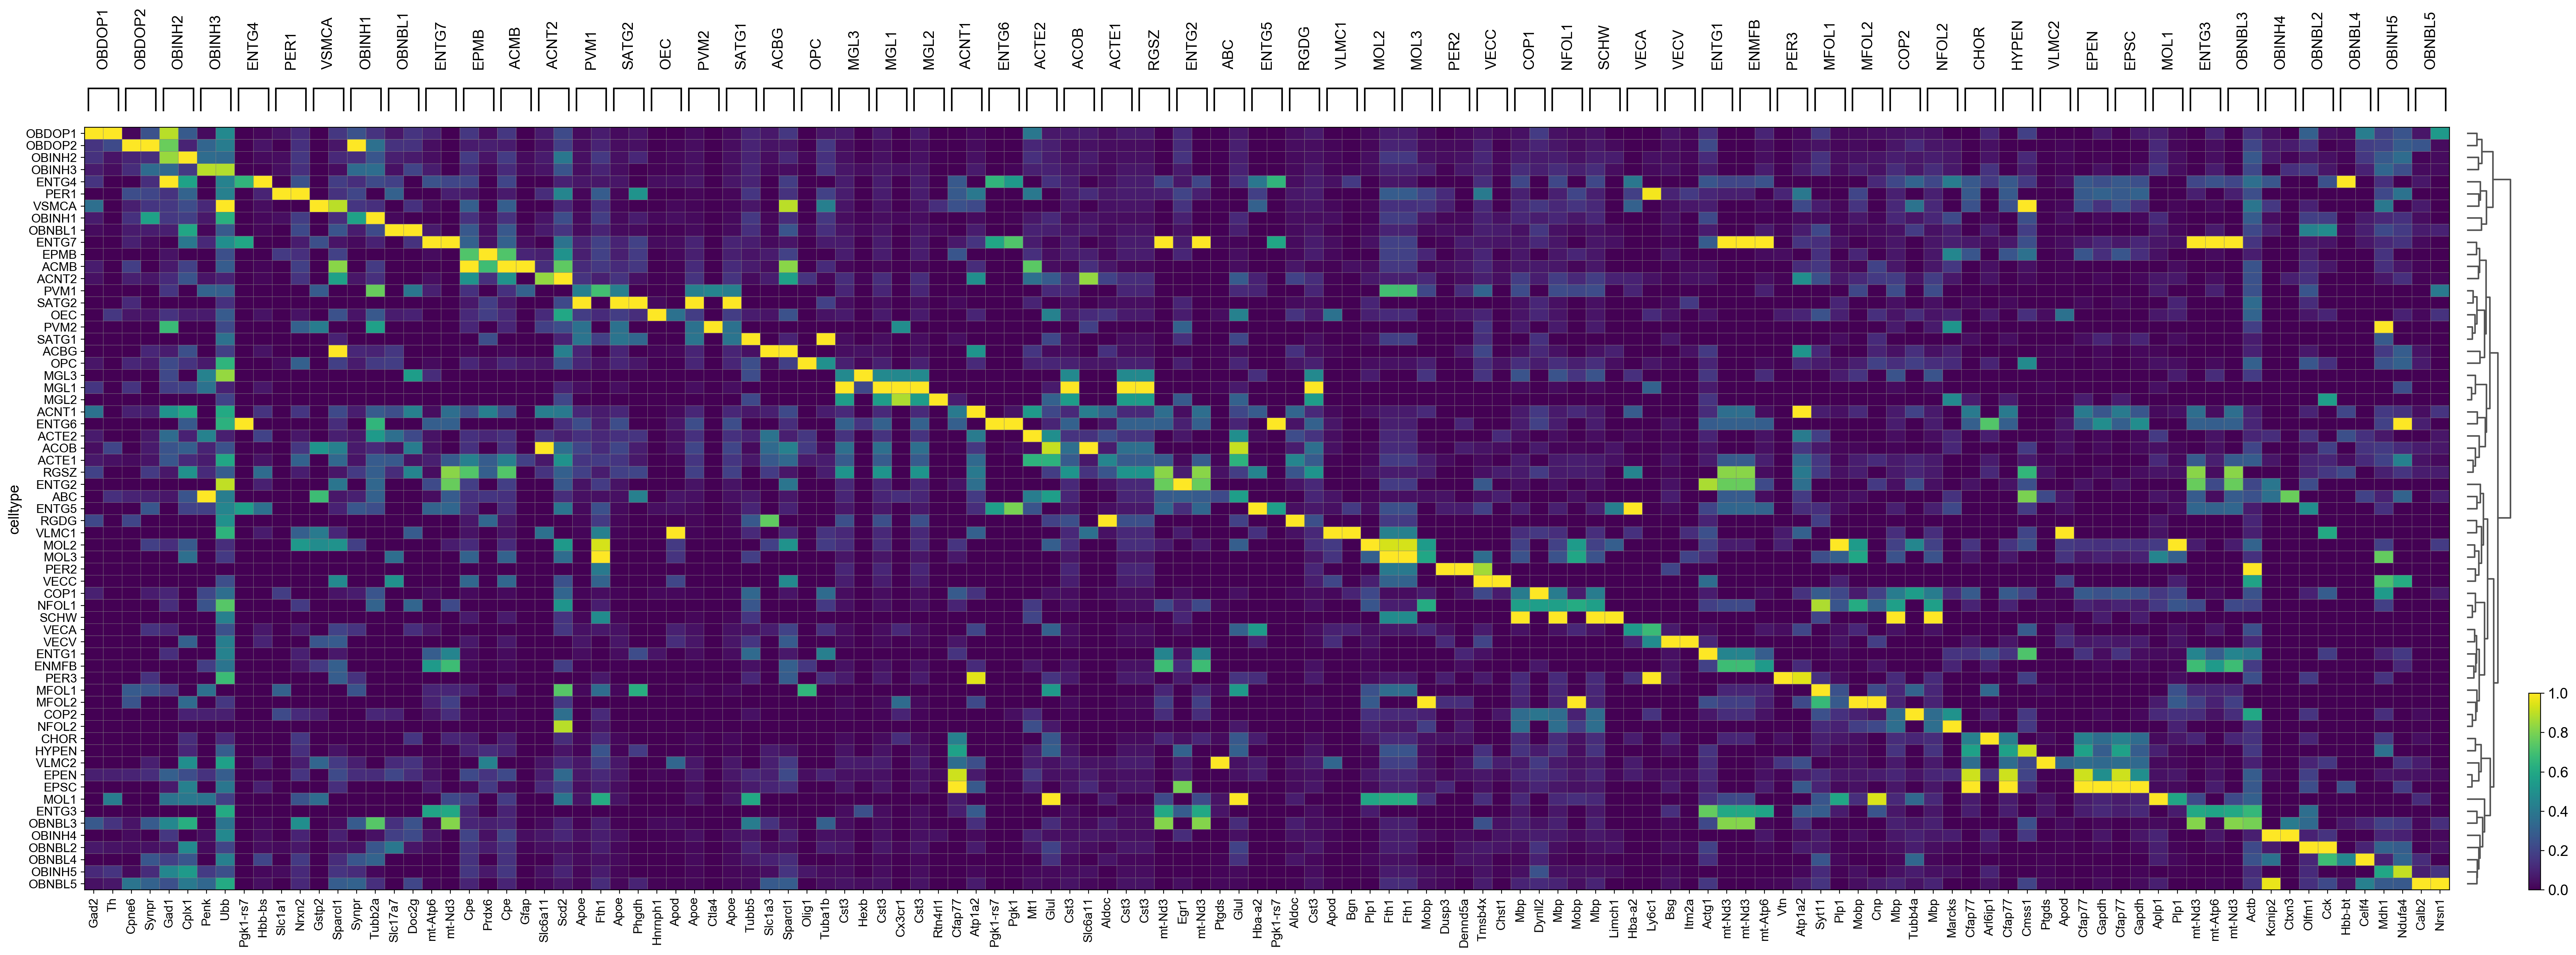

In [29]:
sc.settings.figdir = './'
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=2, standard_scale='var', save='_mob_celltype_de.pdf')

In [28]:
tidy_up_scanpy_de_all(adata, 'celltype').sort_values('pvalsadj').to_excel('results/mob_celltype_de.xlsx', index=False)